## Finilizing Data Generation for 0D Reactor

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
WORKSPACE_PATH  = os.environ['WORKSPACE_PATH']
plt.style.use(WORKSPACE_PATH+'/ROMNet/romnet/extra/postprocessing/presentation.mplstyle')

from scipy.integrate import solve_ivp

pd.options.mode.chained_assignment = None  # default='warn'

from PCAfold import PCA as PCAA

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [2]:
### Input Data

OutputDir  = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_1Cond/'
# TestDir    = WORKSPACE_PATH+'/ROMNet/Data/0DReact_Isobaric_100Cases_Test/'
try:
    os.makedirs(OutputDir)
except OSError as e:
    pass
# try:
#     os.makedirs(TestDir)
# except OSError as e:
#     pass

NVarsRed           = 7

tStratch           = 1.
SOLVER             = 'BDF'

ValidPerc          = 20.

FixedMinVal        = 1.e-12

POD_NAME           = '1'
iPC                = 0

if (POD_NAME == 'All'):
    NPODsFinal = 32
    PODType    = 'All'
else:
    NPODsFinal = 2
    PODType    = 'OneByOne'
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType))
except:
    pass

In [3]:
FileName     = OutputDir + '/Orig/train/ext/SimIdxs.csv'
Data         = pd.read_csv(FileName, header=0)
SimIdxs      = Data.to_numpy(int)


FileName     = OutputDir + '/Orig/train/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
NICs         = len(ICVecs)

In [4]:
if (POD_NAME == 'All'):
    
    Cols   = []
    NewFlg = True
    for iC in range(100):

        Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
        NtsNow               = Nts



        FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]]


        Flg = True
        for iPC in range(NVarsRed):
            if (np.abs( (DataTemp['PC_'+str(iPC+1)][0] - DataTemp['PC_'+str(iPC+1)][len(Data)-1])/DataTemp['PC_'+str(iPC+1)][0] ) < 1.e-4): 
                Flg = False
                break
        
        if Flg:
            DataICTemp  = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols += [str(iC+1)+'_PC_'+str(iPC+1) for iPC in range(NVarsRed)]
            
        else:
            print('iC ', iC)

    tVec              = Data['t']
    DataInput.columns = Cols
    
    yMat              = DataInput.to_numpy()
    
else:
    
    Cols   = []
    NewFlg = True
    for iC in range(NICs):

        Nts                  = SimIdxs[iC,1]-SimIdxs[iC,0]
        NtsNow               = Nts



        FileName             = OutputDir+'/'+str(NVarsRed)+'PC/train/ext/PC.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data['PC_'+str(iPC+1)]

        if (np.abs( (DataTemp[0] - DataTemp[len(Data)-1])/DataTemp[0] ) > 1.e-4):
            DataICTemp  = Data[['PC_'+str(iPC+1) for iPC in range(NVarsRed)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))

    tVec              = Data['t']
    DataInput.columns = Cols

    yMat              = DataInput.to_numpy()
    
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

In [5]:
ICs = DataIC.to_numpy()

In [6]:
DataInput

,1,2,3,4,5,6,7,8,9,10
0,-43.514292,-43.514295,-43.514288,-43.514293,-43.514290,-43.514289,-43.514294,-43.514294,-43.514291,-43.514296
1,-43.514292,-43.514295,-43.514288,-43.514293,-43.514290,-43.514289,-43.514294,-43.514294,-43.514291,-43.514296
2,-43.514292,-43.514295,-43.514288,-43.514293,-43.514290,-43.514289,-43.514294,-43.514294,-43.514291,-43.514296
3,-43.514292,-43.514295,-43.514288,-43.514293,-43.514290,-43.514289,-43.514294,-43.514294,-43.514291,-43.514296
4,-43.514292,-43.514295,-43.514288,-43.514293,-43.514290,-43.514289,-43.514294,-43.514294,-43.514291,-43.514296
...,...,...,...,...,...,...,...,...,...,...
495,11.186708,11.183639,11.189775,11.182109,11.188241,11.179045,11.177508,11.180575,11.185175,11.175974
496,11.184797,11.181730,11.187863,11.180201,11.186330,11.177138,11.175602,11.178667,11.183266,11.174068
497,11.182865,11.179799,11.185929,11.178270,11.184397,11.175209,11.173674,11.176737,11.181334,11.172140
498,11.180910,11.177845,11.183973,11.176317,11.182441,11.173257,11.171722,11.174785,11.179379,11.170190


In [7]:
# NPODs      = 128
# ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
# #'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

# plt.figure(figsize=(8,8))
# for j, Scaling in enumerate(ScalingVec):

#     pca        = PCAA(yMat, scaling=Scaling, n_components=int(NPODs))
#     C          = pca.X_center
#     D          = pca.X_scale
#     A          = pca.A[:,0:NPODs].T
#     L          = pca.L
#     AT         = A.T

#     plt.plot(L, label=Scaling)
    
# plt.ylim([1.e-14, 1.e0])
# plt.yscale('log')
# plt.legend()

/usr/local/lib/python3.8/site-packages/PCAfold/reduction.py:193: RuntimeWarning: invalid value encountered in sqrt
  loadings_matrix[j, i] = (self.A[j, i] * np.sqrt(self.L[i])) / np.sqrt(self.S[j, j])


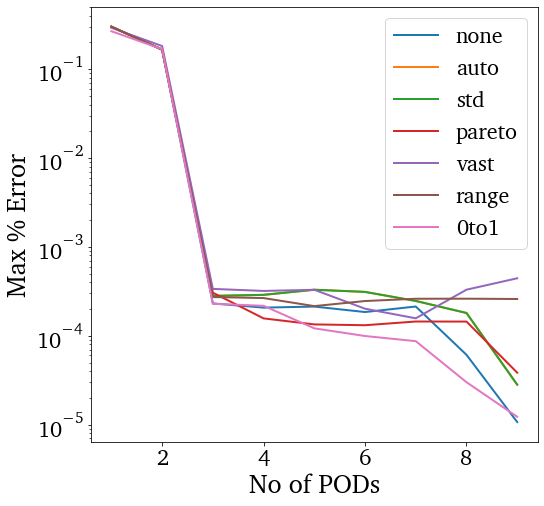

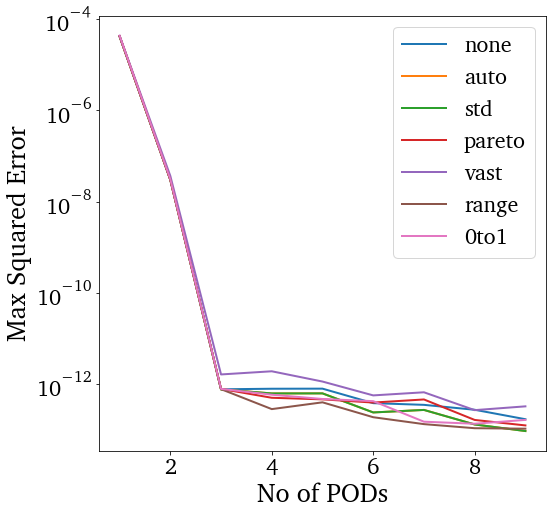

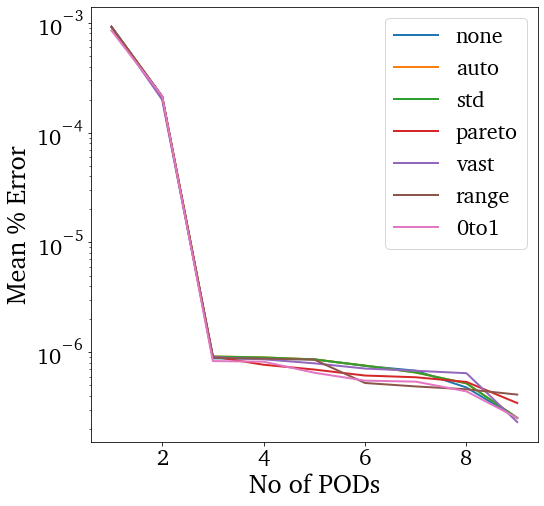

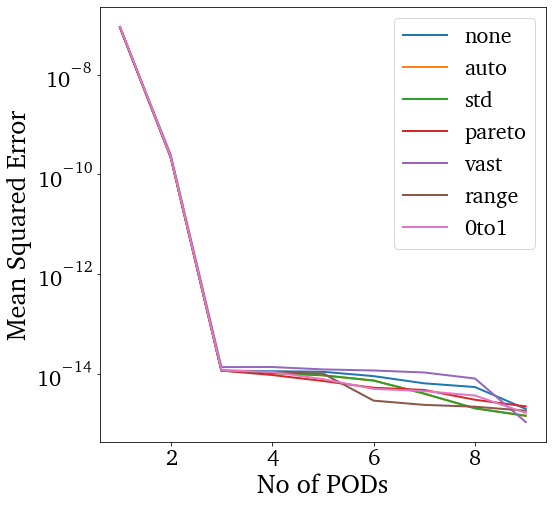

In [8]:
NPODsVec   = np.arange(1,10)
ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
#'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

MaxPerc    = np.zeros((len(NPODsVec), len(ScalingVec)))
MaxSE      = np.zeros((len(NPODsVec), len(ScalingVec)))
MeanPerc   = np.zeros((len(NPODsVec), len(ScalingVec)))
MSE        = np.zeros((len(NPODsVec), len(ScalingVec)))
for i, NPODs in enumerate(NPODsVec):
    #print('NPODs = ', NPODs)
    
    for j, Scaling in enumerate(ScalingVec):

        pca        = PCAA(yMat, scaling=Scaling, n_components=int(NPODs))
        C          = pca.X_center
        D          = pca.X_scale
        A          = pca.A[:,0:NPODs].T
        L          = pca.L
        AT         = A.T

        yMat_pca   = ((yMat - C)/D).dot(AT)
        yMat_      = (yMat_pca.dot(A))*D + C
        
        MaxPerc[i,j]    = np.max(abs((yMat - yMat_)/yMat)*100)
        MaxSE[i,j]      = np.max((yMat - yMat_)**2)
        MeanPerc[i,j]   = np.mean(abs((yMat - yMat_)/yMat)*100)
        MSE[i,j]        = np.mean((yMat - yMat_)**2)

plt.figure(figsize=(8,8))
plt.plot(NPODsVec, MaxPerc, label=ScalingVec)
plt.xlabel('No of PODs')
plt.ylabel('Max % Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(8,8))
plt.plot(NPODsVec, MaxSE, label=ScalingVec)
plt.xlabel('No of PODs')
plt.ylabel('Max Squared Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(8,8))
plt.plot(NPODsVec, MeanPerc, label=ScalingVec)
plt.xlabel('No of PODs')
plt.ylabel('Mean % Error')
plt.legend()
plt.yscale('log')

plt.figure(figsize=(8,8))
plt.plot(NPODsVec, MSE, label=ScalingVec)
plt.xlabel('No of PODs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.yscale('log')

In [9]:
# from __future__ import division, print_function

# import numpy as np

# try:
#     from pylab import plt
# except ImportError:
#     print('Unable to import pylab. R_pca.plot_fit() will not work.')

# try:
#     # Python 2: 'xrange' is the iterative version
#     range = xrange
# except NameError:
#     # Python 3: 'range' is iterative - no need for 'xrange'
#     pass


# class R_pca:

#     def __init__(self, D, mu=None, lmbda=None):
#         self.D = D
#         self.S = np.zeros(self.D.shape)
#         self.Y = np.zeros(self.D.shape)

#         if mu:
#             self.mu = mu
#         else:
#             self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

#         self.mu_inv = 1 / self.mu

#         if lmbda:
#             self.lmbda = lmbda
#         else:
#             self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

#     @staticmethod
#     def frobenius_norm(M):
#         return np.linalg.norm(M, ord='fro')

#     @staticmethod
#     def shrink(M, tau):
#         return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

#     def svd_threshold(self, M, tau):
#         U, S, V = np.linalg.svd(M, full_matrices=False)
#         return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

#     def fit(self, tol=None, max_iter=1000, iter_print=100):
#         iter = 0
#         err = np.Inf
#         Sk = self.S
#         Yk = self.Y
#         Lk = np.zeros(self.D.shape)

#         if tol:
#             _tol = tol
#         else:
#             _tol = 1E-7 * self.frobenius_norm(self.D)

#         #this loop implements the principal component pursuit (PCP) algorithm
#         #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
#         while (err > _tol) and iter < max_iter:
#             Lk = self.svd_threshold(
#                 self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
#             Sk = self.shrink(
#                 self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
#             Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
#             err = self.frobenius_norm(self.D - Lk - Sk)
#             iter += 1
#             if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
#                 print('iteration: {0}, error: {1}'.format(iter, err))

#         self.L = Lk
#         self.S = Sk
#         return Lk, Sk

#     def plot_fit(self, size=None, tol=0.1, axis_on=True):

#         n, d = self.D.shape

#         if size:
#             nrows, ncols = size
#         else:
#             sq = np.ceil(np.sqrt(n))
#             nrows = int(sq)
#             ncols = int(sq)

#         ymin = np.nanmin(self.D)
#         ymax = np.nanmax(self.D)
#         print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

#         numplots = np.min([n, nrows * ncols])
#         plt.figure()

#         for n in range(numplots):
#             plt.subplot(nrows, ncols, n + 1)
#             plt.ylim((ymin - tol, ymax + tol))
#             plt.plot(self.L[n, :] + self.S[n, :], 'r')
#             plt.plot(self.L[n, :], 'b')
#             if not axis_on:
#                 plt.axis('off')

In [10]:
# LL, SS = R_pca(yMat).fit(max_iter=1500)#tol=5.e-5)

In [11]:
# iVar = 0

# fig = plt.figure(figsize=(12,8))
# plt.plot(yMat[:,iVar])
# plt.plot(LL[:,iVar])


# fig = plt.figure(figsize=(12,8))
# plt.plot(SS[:,iVar])

In [12]:
#NPODsFinal = 60

pca        = PCAA(yMat, scaling='none', n_components=NPODsFinal, nocenter=False)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:NPODsFinal].T
L          = pca.L
AT         = A.T
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (2, 10)
[PCA] 


In [13]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

[PCA] Shape of yMat_pca =  (500, 2)
[PCA]  Max % Error =  0.16565999381575724
[PCA]  Max      SE =  3.020098810553426e-08
[PCA] Mean % Error =  0.000213400412351104
[PCA]          MSE =  2.2220800686168182e-10


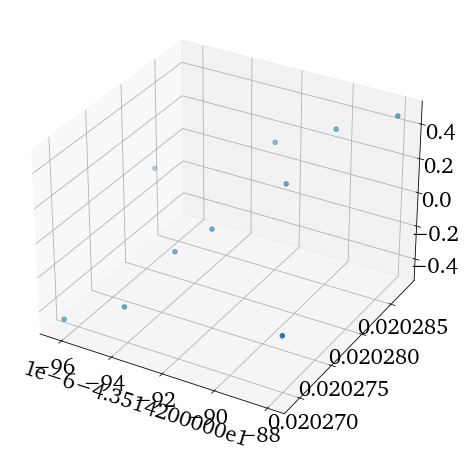

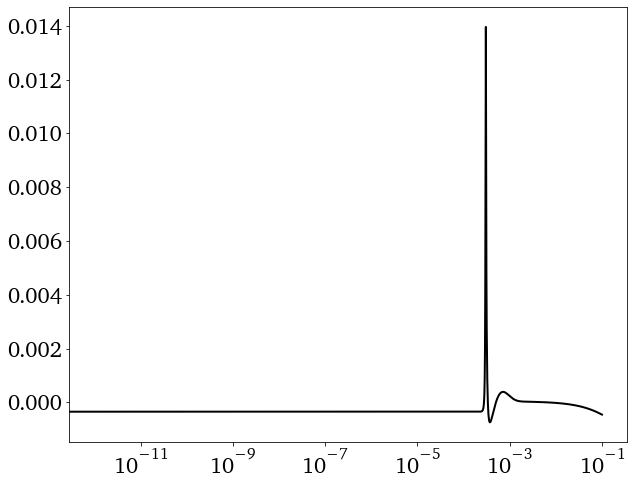

In [14]:
iVar    = 1

Eta_1   = DataIC.to_numpy()[:,0]
Eta_2   = DataIC.to_numpy()[:,1]
Alpha_1 = A[iVar,:]

fig = plt.figure(figsize=(12,8))
ax  = fig.add_subplot(projection='3d')
ax.scatter(Eta_1, Eta_2, Alpha_1)

plt.figure(figsize=(10,8))
plt.plot(tVec, yMat_pca[:,iVar], '-k')
plt.xscale('log')
#plt.xlim([1.e-6,1.e-4])

In [15]:
# #NPODsFinal = 5

# pca        = PCAA(LL, scaling='pareto', n_components=NPODsFinal, nocenter=False)
# C          = pca.X_center
# D          = pca.X_scale
# A          = pca.A[:,0:NPODsFinal].T
# L          = pca.L
# AT         = A.T
# print('[PCA] Shape of A        = ', A.shape)
# print('[PCA] ')

In [16]:
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/')
except:
    pass

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/A.csv'
np.savetxt(FileName, A, delimiter=',')

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/C.csv'
np.savetxt(FileName, C, delimiter=',')

FileName    = OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/ROM/D.csv'
np.savetxt(FileName, D, delimiter=',')

In [17]:
# #yMat_pca    = pca.transform(yMat, nocenter=False)
# yMat_pca   = ((LL - C)/D).dot(AT)

# LL_      = (yMat_pca.dot(A))*D + C
# print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
# print('[PCA]  Max % Error = ', np.max(abs((LL - LL_)/LL)*100))
# print('[PCA]  Max      SE = ', np.max((LL - LL_)**2))
# print('[PCA] Mean % Error = ', np.mean(abs((LL - LL_)/LL)*100))
# print('[PCA]          MSE = ', np.mean((LL - LL_)**2))

# yMat_    = LL_ + SS
# print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
# print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
# print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
# print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

In [18]:
# iVar    = 0

# Eta_1   = DataIC.to_numpy()[:,0]
# Eta_2   = DataIC.to_numpy()[:,1]
# Alpha_1 = A[iVar,:]

# fig = plt.figure(figsize=(12,8))
# ax  = fig.add_subplot(projection='3d')
# ax.scatter(Eta_1, Eta_2, Alpha_1)

# plt.figure(figsize=(10,8))
# plt.plot(tVec, yMat_pca[:,iVar], '-k')
# plt.xscale('log')
# #plt.xlim([1.e-6,1.e-4])

(1e-06, 1000.0)

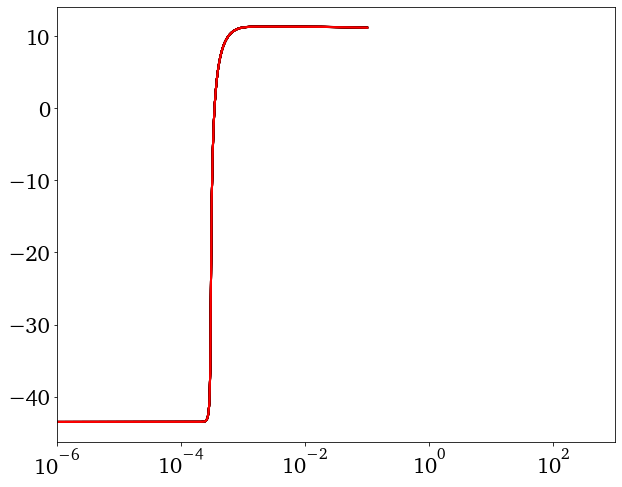

In [21]:
iVarVec = np.arange(0,yMat.shape[1])#[10, 20, 30, 40]

plt.figure(figsize=(10,8))
for iVar in iVarVec:
    plt.plot(tVec, yMat[:,iVar], '-k')
    plt.plot(tVec, yMat_[:,iVar], '-r')
plt.xscale('log')
plt.xlim([1.e-6,1.e3])

NameError: name 'max_val' is not defined

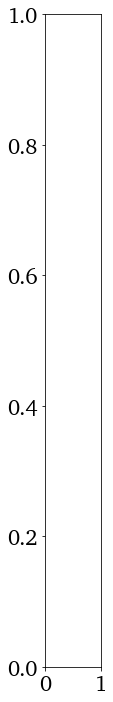

In [20]:
fig, ax = plt.subplots(figsize=(1,12))

#min_val, max_val = -30, 30

intersection_matrix = np.random.randint(0, 10, size=(max_val, max_val))

ax.matshow(yMat)#, cmap=plt.cm.Blues)

In [ ]:
Vars             = ['POD_'+str(iPOD+1) for iPOD in range(NPODsFinal)]
Data             = pd.DataFrame(yMat_pca, columns=Vars)
tVec[tVec == 0.] = FixedMinVal
Data['t']        = tVec
Data['log(t)']   = np.log(tVec)
Data['log10(t)'] = np.log10(tVec)


Data

In [ ]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME)
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/')
except:
    pass

In [ ]:
data_id    = 'pts'

DataNoZero           = Data[Data['t'] >= FixedMinVal]
n_points             = len(DataNoZero)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/valid/'+data_id+'/Output.csv', index=False)

In [ ]:
DataNoZero           = Data
n_points             = len(DataNoZero)

n_test               = n_points


try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/')
except:
    pass

DataInput  = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataInput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/Input.csv', index=False)

DataOutput = DataNoZero[['t', 'log10(t)', 'log(t)'] + Vars]
DataOutput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Trunk/test/ext/Output.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME)
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/')
except:
    pass

In [ ]:
OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'

In [ ]:
data_id    = 'pts'

n_points             = len(DataIC)

idx                  = np.arange(n_points)
train_idx, valid_idx = train_test_split(idx, test_size=ValidPerc/100, random_state=42)

n_valid              = len(valid_idx)
n_train              = len(train_idx)


try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/')
except:
    pass
try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/')
except:
    pass

DataInput  = DataIC
DataInput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/Input.csv', index=False)
DataInput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/Input.csv', index=False)

DataOutput = pd.DataFrame(np.concatenate([A.T, C[...,np.newaxis], D[...,np.newaxis]], axis=1), columns=['POD_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
DataOutput.iloc[train_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/train/'+data_id+'/Output.csv', index=False)
DataOutput.iloc[valid_idx].to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/valid/'+data_id+'/Output.csv', index=False)

In [ ]:
n_points             = len(DataIC)

n_test               = n_points

try:
    os.makedirs(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/')
except:
    pass

DataInput  = DataIC
DataInput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/Input.csv', index=False)

DataOutput = pd.DataFrame(np.concatenate([A.T, C[...,np.newaxis], D[...,np.newaxis]], axis=1), columns=['POD_'+str(i+1) for i in range(A.shape[0])]+['C','D'])
DataOutput.to_csv(OutputDir+'/'+str(NVarsRed)+'PC/'+str(PODType)+'/POD_'+POD_NAME+'/Branch/test/ext/Output.csv', index=False)

In [ ]:
# NComp = 2

# pca        = PCAA(ICs, scaling='none', n_components=NComp)
# C          = pca.X_center
# D          = pca.X_scale
# A          = pca.A[:,0:NComp].T
# L          = pca.L
# AT         = A.T
# print('[PCA] Shape of A        = ', A.shape)
# print('[PCA] ')

In [ ]:
# #yMat_pca    = pca.transform(yMat, nocenter=False)
# ICs_pca   = ((ICs - C)/D).dot(AT)

# ICs_      = (ICs_pca.dot(A))*D + C
# print('[PCA] Shape of yMat_pca = ', ICs_pca.shape)
# print('[PCA]  Max % Error = ', np.max(abs((ICs - ICs_)/ICs)*100))
# print('[PCA]  Max      SE = ', np.max((ICs - ICs_)**2))
# print('[PCA] Mean % Error = ', np.mean(abs((ICs - ICs_)/ICs)*100))
# print('[PCA]          MSE = ', np.mean((ICs - ICs_)**2))

In [ ]:
# A